In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import pyart
import glob
import sys
sys.path.append('../')
from core import basis_set
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
from plotting import *

%matplotlib inline

colors = {
    'C': 'navy',
    'G': 'seagreen',
    'N': 'orangered',
    'GB':'crimson',
    'CB':'darkorchid',
    'GM':'mediumturquoise',
    'CM':'darkcyan'
}
cmap = f'pyart_balance'

In [5]:
birds = {
    'naive': ['Rb291', 'C49', 'C54a', 'C43', 'Rb279']#, 'C378'],
    # 'even': ['C234','C329','C318'],
    # 'odd': ['C332','C331','C338']
}

In [7]:
win=100
nbasis=15
conditions = ['C','G','CB','GB','GM','CM','N']
comparisons = [
    ('GB','CB'),('GB', 'GM'),('GM','CB')
]
scores = []
for dataset in birds.keys():
    if dataset!='naive':
        continue
    for exp in ['nat8b', 'synth8b']:
        with open(f'../../inputs/stimuli_lists/{exp}_motif_list.txt', 'r') as file:
            motifs = file.read().split('\n')
        gtype = 'a' if exp=='synth8b' else ''
        gaps = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_gaptimes.csv', index_col=[0,1])
        gaplocs = [1,2] if exp!='synth8b' else [2,4]
        for bird in birds[dataset]:
            spectrograms = pd.read_csv(f"/scratch/bple/induction/{exp}/spectrograms.csv", index_col=[0,1])
            models = joblib.load(f"/scratch/bple/induction/models/{exp}/iota/{bird}_pls_model_win{win}_basis{nbasis}.pkl")
            responses = pd.read_hdf(f"/scratch/bple/induction/{exp}/{dataset}/{bird}_delemb_win{win}_basis{nbasis}.h5", key="Induction")
            if models['units']!='all':
                responses = responses[models['units']].copy()
            
            cscores = get_scores(
                exp, models, spectrograms, responses, motifs, gtype,
                conditions, comparisons, full=False
            )
            cscores['exp'] = exp
            cscores['dataset'] = dataset
            cscores['bird'] = bird
            cscores = cscores.drop('ndim', axis=1)
            scores.append(cscores.copy())

scores = pd.concat(scores).set_index(['dataset','exp','bird','comp', 'motif', 'gap']).unstack('comp').droplevel(0, axis=1)

Exp nat8b best # of components is 6
Exp nat8b best # of components is 11
Exp nat8b best # of components is 9
Exp nat8b best # of components is 8
Exp nat8b best # of components is 8
Exp synth8b best # of components is 12
Exp synth8b best # of components is 35
Exp synth8b best # of components is 8
Exp synth8b best # of components is 9
Exp synth8b best # of components is 6


In [8]:
scores['S'] = 0.25 *\
    np.sqrt(scores['GBCB']+scores['GBGM']+scores['GMCB']) *\
    np.sqrt(-scores['GBCB']+scores['GBGM']+scores['GMCB']) *\
    np.sqrt(scores['GBCB']-scores['GBGM']+scores['GMCB']) *\
    np.sqrt(scores['GBCB']+scores['GBGM']-scores['GMCB'])         
scores['d'] = scores['S']*2/scores['GMCB']
scores.head()

comp                                GBCB      GBGM      GMCB         S  \
dataset exp   bird motif   gap                                           
naive   nat8b C43  nat8mk0 1    0.276294  0.904898  0.937782  0.124947   
                           2    0.395262  0.528553  0.722246  0.102220   
                   nat8mk1 1    0.487631  0.485752  0.798622  0.111105   
                           2    0.188941  0.360909  0.316642  0.029879   
                   nat8mk2 1    0.337334  0.459271  0.493451  0.074755   

comp                                   d  
dataset exp   bird motif   gap            
naive   nat8b C43  nat8mk0 1    0.266473  
                           2    0.283061  
                   nat8mk1 1    0.278242  
                           2    0.188726  
                   nat8mk2 1    0.302987

In [9]:
test = scores.droplevel('dataset').apply(
    lambda df:
    (-df['GBCB']+df['GBGM']) / np.abs(-df['GBCB']+df['GBGM']) *
    np.sqrt(np.abs(-df['GBCB']+df['GBGM']) / df['d']),
    axis=1
).to_frame(name='RI')
test = test.reorder_levels(['exp','bird','motif','gap'])
# test.to_csv('./stats/RI-iota.csv')
test.head()

RI
exp   bird motif   gap          
nat8b C43  nat8mk0 1    1.535897
                   2    0.686214
           nat8mk1 1   -0.082177
                   2    0.954571
           nat8mk2 1    0.634388

In [10]:
sns.set_style('whitegrid')

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 2

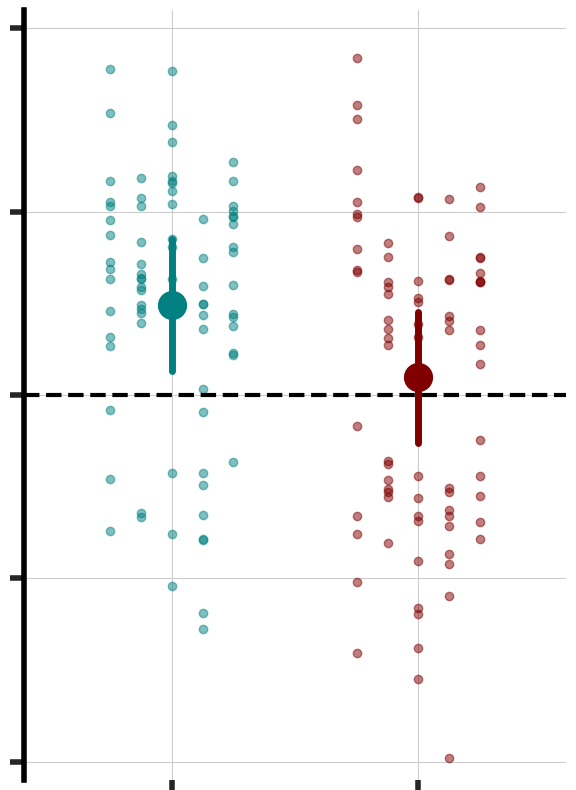

In [11]:
ax = plt.figure(figsize=(7,10)).add_subplot()


subjects = test.index.get_level_values('bird').unique()
space = np.linspace(-0.25,0.25,len(subjects))
for isub, sub in enumerate(subjects):
    ax.plot(
        np.repeat(0+space[isub], 16), test.loc['nat8b'].loc[sub],
        color='teal',ls='',marker='o', alpha=0.5
    )
    ax.plot(
        np.repeat(1+space[isub], 16), test.loc['synth8b'].loc[sub],
        color='maroon',ls='',marker='o', alpha=0.5
    )
ax.axhline(0, ls='--', lw=3, color='black')

ax.plot(
    [0,0], [0.131, 0.850],
    color='teal', lw=5
)
ax.plot(
    [1,1], [-0.264, 0.455],
    color='maroon', lw=5
)
ax.plot(
    0, 0.4906,
    color='teal', ls='', marker='o', markersize=20, markerfacecolor='teal'
)
ax.plot(
    1, 0.0959,
    color='maroon', ls='', marker='o', markersize=20, markerfacecolor='maroon'
)

ax.set_ylim(-2.1,2.1)
ax.set_xlim(-0.6,1.6)
ax.set_yticks([-2,-1,0,1,2], [])
ax.set_xticks([0,1], [])
plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, bottom=True, right=True)

In [ ]:
# synfam = pd.concat([
#     test.loc['even','synth8b',:].loc[[f"synth8mk{i}" for i in [0,2,4,6]]],
#     test.loc['odd','synth8b',:].loc[[f"synth8mk{i}" for i in [1,3,5,7]]],
# ]).groupby('bird').mean()
# synunf = pd.concat([
#     test.loc['odd','synth8b',:].loc[[f"synth8mk{i}" for i in [0,2,4,6]]],
#     test.loc['even','synth8b',:].loc[[f"synth8mk{i}" for i in [1,3,5,7]]],
# ]).groupby('bird').mean()

# synnat = test.loc[['even','odd']].xs('nat8b', level='exp').groupby('bird').mean()
# nainat = test.sort_index().loc['naive','nat8b'].swaplevel('motif','bird').sort_index()#.groupby('bird').mean()
# naisyn = test.sort_index().loc['naive','synth8b'].swaplevel('motif','bird').sort_index()#.groupby('bird').mean()

# ax = plt.figure(figsize=(5,5)).add_subplot()

# subris = pd.concat([
#     synnat, synfam, synunf
# ], axis=1)

# for i, row in subris.iterrows():
#     ax.plot([0,1,2], row, label=i)
# ax.legend()
# ax.set_ylim(-2,2)
# ax.set_xlim(-0.2,2.2)
# ax.set_xticks([0,1,2],[])
# #ax.set_yticks([-1,0,1],[])
# ax.axhline(y=0, color='black', ls='--', lw=1)
# sns.despine(ax=ax, top=True, bottom=True, right=True)